In [1]:
!pip install -q ultralytics diffusers transformers accelerate opencv-python pillow huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.5 MB/s eta 0:00:00


In [2]:
import random
import urllib.request

import cv2
import numpy as np
import torch
from google.colab import files

from diffusers import DPMSolverMultistepScheduler, StableDiffusionXLPipeline

In [3]:
from PIL import Image

# Upload Image
uploaded = files.upload()
filename = list(uploaded.keys())[0]
image = Image.open(filename).convert("RGB")
image_np = np.array(image)

Saving img.jpg to img.jpg


In [4]:
def merge_images(original, new_image, offset, direction):
    if direction in ["left", "right"]:
        merged_image = np.zeros((original.shape[0], original.shape[1] + offset, 3), dtype=np.uint8)
    elif direction in ["top", "bottom"]:
        merged_image = np.zeros((original.shape[0] + offset, original.shape[1], 3), dtype=np.uint8)

    if direction == "left":
        merged_image[:, offset:] = original
        merged_image[:, : new_image.shape[1]] = new_image
    elif direction == "right":
        merged_image[:, : original.shape[1]] = original
        merged_image[:, original.shape[1] + offset - new_image.shape[1] : original.shape[1] + offset] = new_image
    elif direction == "top":
        merged_image[offset:, :] = original
        merged_image[: new_image.shape[0], :] = new_image
    elif direction == "bottom":
        merged_image[: original.shape[0], :] = original
        merged_image[original.shape[0] + offset - new_image.shape[0] : original.shape[0] + offset, :] = new_image

    return merged_image

In [5]:
def slice_image(image):
    height, width, _ = image.shape
    slice_size = min(width // 2, height // 3)

    slices = []

    for h in range(3):
        for w in range(2):
            left = w * slice_size
            upper = h * slice_size
            right = left + slice_size
            lower = upper + slice_size

            if w == 1 and right > width:
                left -= right - width
                right = width
            if h == 2 and lower > height:
                upper -= lower - height
                lower = height

            slice = image[upper:lower, left:right]
            slices.append(slice)

    return slices

In [6]:
def process_image(
    image,
    fill_color=(0, 0, 0),
    mask_offset=50,
    blur_radius=500,
    expand_pixels=256,
    direction="left",
    inpaint_mask_color=50,
    max_size=1024,
):
    height, width = image.shape[:2]

    new_height = height + (expand_pixels if direction in ["top", "bottom"] else 0)
    new_width = width + (expand_pixels if direction in ["left", "right"] else 0)

    if new_height > max_size:
        # If so, crop the image from the opposite side
        if direction == "top":
            image = image[:max_size, :]
        elif direction == "bottom":
            image = image[new_height - max_size :, :]
        new_height = max_size

    if new_width > max_size:
        # If so, crop the image from the opposite side
        if direction == "left":
            image = image[:, :max_size]
        elif direction == "right":
            image = image[:, new_width - max_size :]
        new_width = max_size

    height, width = image.shape[:2]

    new_image = np.full((new_height, new_width, 3), fill_color, dtype=np.uint8)
    mask = np.full_like(new_image, 255, dtype=np.uint8)
    inpaint_mask = np.full_like(new_image, 0, dtype=np.uint8)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    inpaint_mask = cv2.cvtColor(inpaint_mask, cv2.COLOR_BGR2GRAY)

    if direction == "left":
        new_image[:, expand_pixels:] = image[:, : max_size - expand_pixels]
        mask[:, : expand_pixels + mask_offset] = inpaint_mask_color
        inpaint_mask[:, :expand_pixels] = 255
    elif direction == "right":
        new_image[:, :width] = image
        mask[:, width - mask_offset :] = inpaint_mask_color
        inpaint_mask[:, width:] = 255
    elif direction == "top":
        new_image[expand_pixels:, :] = image[: max_size - expand_pixels, :]
        mask[: expand_pixels + mask_offset, :] = inpaint_mask_color
        inpaint_mask[:expand_pixels, :] = 255
    elif direction == "bottom":
        new_image[:height, :] = image
        mask[height - mask_offset :, :] = inpaint_mask_color
        inpaint_mask[height:, :] = 255

    # mask blur
    if blur_radius % 2 == 0:
        blur_radius += 1
    mask = cv2.GaussianBlur(mask, (blur_radius, blur_radius), 0)

    # telea inpaint
    _, mask_np = cv2.threshold(inpaint_mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    inpaint = cv2.inpaint(new_image, mask_np, 3, cv2.INPAINT_TELEA)

    # convert image to tensor
    inpaint = cv2.cvtColor(inpaint, cv2.COLOR_BGR2RGB)
    inpaint = torch.from_numpy(inpaint).permute(2, 0, 1).float()
    inpaint = inpaint / 127.5 - 1
    inpaint = inpaint.unsqueeze(0).to("cuda")

    # convert mask to tensor
    mask = torch.from_numpy(mask)
    mask = mask.unsqueeze(0).float() / 255.0
    mask = mask.to("cuda")

    return inpaint, mask

In [7]:
def image_resize(image, new_size=1024):
    height, width = image.shape[:2]

    aspect_ratio = width / height
    new_width = new_size
    new_height = new_size

    if aspect_ratio != 1:
        if width > height:
            new_height = int(new_size / aspect_ratio)
        else:
            new_width = int(new_size * aspect_ratio)

    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

    return image

In [8]:
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "SG161222/RealVisXL_V4.0",
    torch_dtype=torch.float16,
    variant="fp16",
    custom_pipeline="pipeline_stable_diffusion_xl_differential_img2img",
).to("cuda")
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config, use_karras_sigmas=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

(…)ble_diffusion_xl_differential_img2img.py: 0.00B [00:00, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
pipeline.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="sdxl_models",
    weight_name=[
        "ip-adapter-plus_sdxl_vit-h.safetensors",
    ],
    image_encoder_folder="models/image_encoder",
)
pipeline.set_ip_adapter_scale(0.1)

ip-adapter-plus_sdxl_vit-h.safetensors:   0%|          | 0.00/848M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.53G [00:00<?, ?B/s]

In [10]:
def generate_image(prompt, negative_prompt, image, mask, ip_adapter_image, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator(device="cpu").manual_seed(seed)

    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        width=1024,
        height=1024,
        guidance_scale=4.0,
        num_inference_steps=25,
        original_image=image,
        image=image,
        strength=1.0,
        map=mask,
        generator=generator,
        ip_adapter_image=[ip_adapter_image],
        output_type="np",
    ).images[0]

    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [ ]:
# prompt = "Person sitting in a chair inside a room"
# negative_prompt = ""
# direction = "right"  # left, right, top, bottom
# inpaint_mask_color = 50  # lighter use more of the Telea inpainting
# expand_pixels = 256  # I recommend to don't go more than half of the picture so it has context
# times_to_expand = 4


In [ ]:
# # with urllib.request.urlopen(url) as url_response:
# #     img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)

# # original = cv2.imdecode(img_array, -1)

# original = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
# image = image_resize(original)
# expand_pixels_to_square = 1024 - image.shape[1]  # image.shape[1] for horizontal, image.shape[0] for vertical
# image, mask = process_image(
#     image, expand_pixels=expand_pixels_to_square, direction=direction, inpaint_mask_color=inpaint_mask_color
# )

In [ ]:
# ip_adapter_image = []
# for index, part in enumerate(slice_image(original)):
#     ip_adapter_image.append(part)

# generated = generate_image(prompt, negative_prompt, image, mask, ip_adapter_image)
# final_image = generated

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# for i in range(times_to_expand):
#     image, mask = process_image(
#         final_image, direction=direction, expand_pixels=expand_pixels, inpaint_mask_color=inpaint_mask_color
#     )

#     ip_adapter_image = []
#     for index, part in enumerate(slice_image(generated)):
#         ip_adapter_image.append(part)

#     generated = generate_image(prompt, negative_prompt, image, mask, ip_adapter_image)
#     final_image = merge_images(final_image, generated, 256, direction)

# cv2.imwrite("result.png", final_image)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

True

In [11]:
import matplotlib.pyplot as plt

def display(new_final):
  # SHOW RESULTS
  plt.figure(figsize=(30, 20)) # Increased figure height to accommodate two images

  plt.subplot(2, 1, 1) # 2 rows, 1 column, second plot
  plt.imshow(image) # Assuming 'original' is the variable holding the first image
  plt.title("Original Image")
  plt.axis("off")

  plt.subplot(2, 1, 2) # 2 rows, 1 column, first plot
  plt.imshow(new_final)
  plt.title("Final Image")
  plt.axis("off")


  plt.show()

In [12]:
def run(image, original, expand_pixels, expand_pixels_to_square, direction, inpaint_mask_color, prompt, negative_prompt, times_to_expand):
  image, mask = process_image(
      image, expand_pixels=expand_pixels_to_square, direction=direction, inpaint_mask_color=inpaint_mask_color
  )

  ip_adapter_image = []
  for index, part in enumerate(slice_image(original)):
      ip_adapter_image.append(part)


  generated = generate_image(prompt, negative_prompt, image, mask, ip_adapter_image)
  final_image = generated


  for i in range(times_to_expand):
      image, mask = process_image(
          final_image, direction=direction, expand_pixels=expand_pixels, inpaint_mask_color=inpaint_mask_color
      )

      ip_adapter_image = []
      for index, part in enumerate(slice_image(generated)):
          ip_adapter_image.append(part)

      generated = generate_image(prompt, negative_prompt, image, mask, ip_adapter_image)
      final_image = merge_images(final_image, generated, 256, direction)

  new_final = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
  return new_final

In [13]:
def concat(generated_images, shape , direction):
  if direction == 'right' or direction == 'left':
    blend_width = 64
    cropped = generated_images[0][:, shape[1]:]

    # if generated_images[0].shape[0] != generated_images[1].shape[0]:
    #     generated_images[1] = cv2.resize(generated_images[1], (int(generated_images[1].shape[1] * (generated_images[1].shape[0] / generated_images[1].shape[0])), generated_images[1].shape[0]))

    # # Horizontally concatenate images
    # concatenated_image = cv2.hconcat([generated_images[1], cropped])
    # Split parts
    left_part = generated_images[1][:, :-blend_width]
    right_part = cropped[:, blend_width:]

    # Get overlapping region
    blend_left = generated_images[1][:, -blend_width:]
    blend_right = cropped[:, :blend_width]

    # Create blended region
    blended = np.zeros_like(blend_left)
    for i in range(blend_width):
        alpha = i / blend_width
        blended[:, i] = cv2.addWeighted(blend_left[:, i], 1 - alpha, blend_right[:, i], alpha, 0)

    # Concatenate all parts
    merged = np.concatenate((left_part, blended, right_part), axis=1)
    return merged


  else: #top , bottom
    blend_height = 64
    cropped = generated_images[1][shape[0]:, :]  # remove top 'shape[0]' pixels

    # Ensure both images have the same width
    if cropped.shape[1] != generated_images[0].shape[1]:
        new_width = generated_images[0].shape[1]
        cropped = cv2.resize(cropped, (new_width, cropped.shape[0]))

    # concatenated_image = cv2.vconcat([generated_images[0], cropped])

    # Split non-overlapping parts
    top_part = generated_images[0][:-blend_height, :]
    bottom_part = cropped[blend_height:, :]

    # Get overlapping region
    blend_top = generated_images[0][-blend_height:, :]
    blend_bottom = cropped[:blend_height, :]

    # Create blended region
    blended = np.zeros_like(blend_top)
    for i in range(blend_height):
        alpha = i / blend_height
        blended[i, :] = cv2.addWeighted(blend_top[i, :], 1 - alpha, blend_bottom[i, :], alpha, 0)

    # Concatenate: top + blended + bottom
    merged = np.concatenate((top_part, blended, bottom_part), axis=0)
    return merged

  return generated_images[0]

In [14]:
def generate_final_image(directions, image_np):
  generated_images = []

  for direction in directions:
    prompt = ""
    negative_prompt = ""
    direction = direction  # left, right, top, bottom
    inpaint_mask_color = 50  # lighter use more of the Telea inpainting
    expand_pixels = 256  # I recommend to don't go more than half of the picture so it has context
    times_to_expand = 2

    original = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    image = image_resize(original)
    if direction == 'right' or direction == 'left':
      expand_pixels_to_square = 1024 - image.shape[1]  # image.shape[1] for horizontal, image.shape[0] for vertical
    else:
      expand_pixels_to_square = 1024 - image.shape[0]  # image.shape[1] for horizontal, image.shape[0] for vertical

    final_image = run(image, original, expand_pixels, expand_pixels_to_square, direction, inpaint_mask_color, prompt, negative_prompt, times_to_expand)

    generated_images.append(final_image)

  return concat(generated_images, image.shape, direction) , generated_images

In [15]:
horizontal = ['right', 'left']
vertical = ['top', 'bottom']

In [20]:
final_image , generated_images = generate_final_image(horizontal, image_np)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

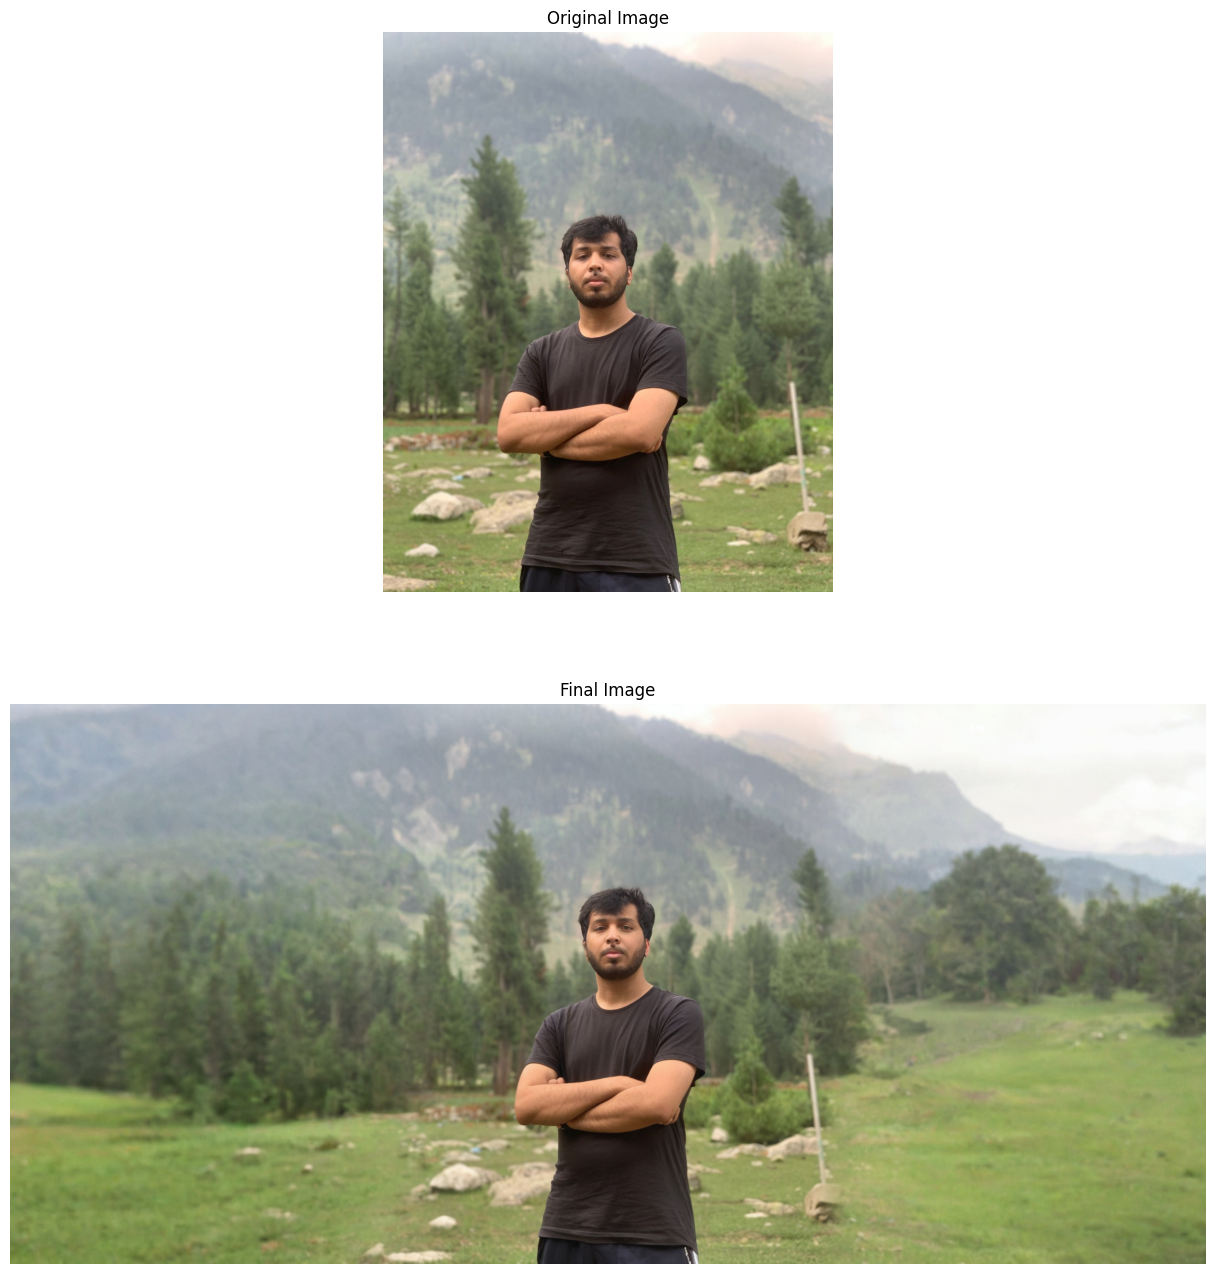

In [21]:
display(final_image)

In [23]:
final_image , generated_images = generate_final_image(vertical, image_np)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

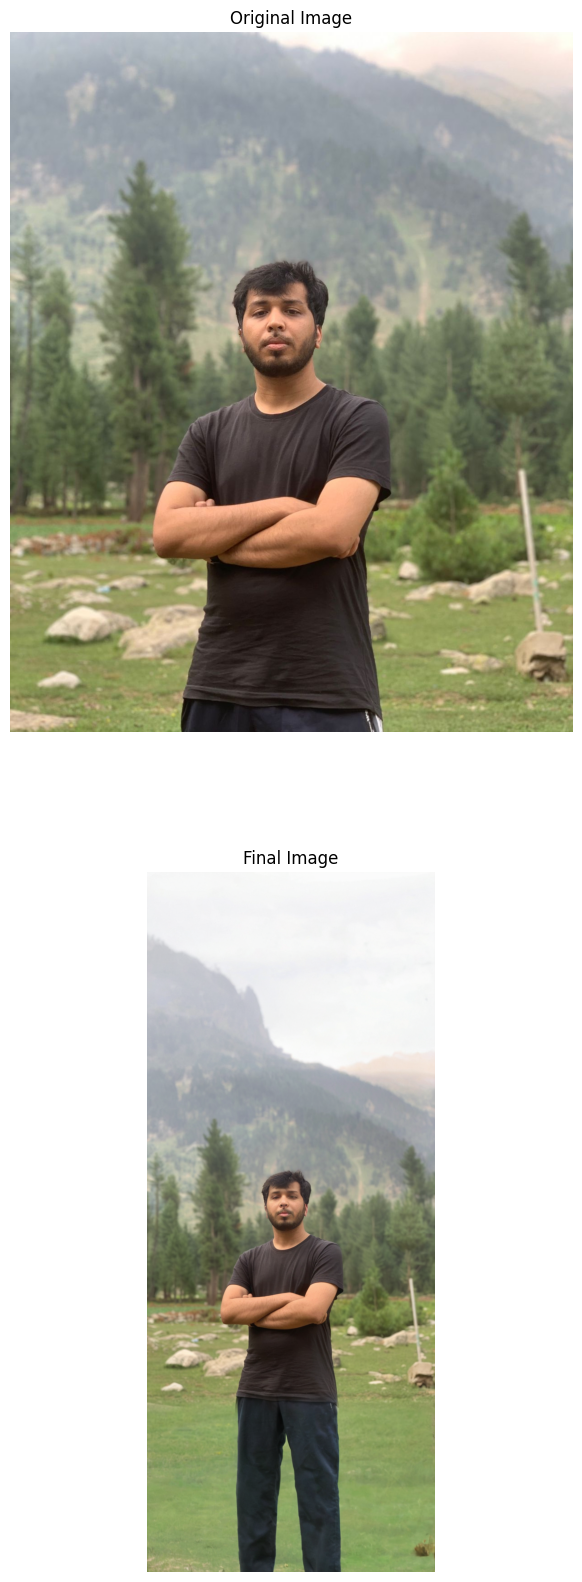

In [30]:
display(final_image)

In [31]:
# Upload Image
uploaded = files.upload()
filename = list(uploaded.keys())[0]
image = Image.open(filename).convert("RGB")
image_np = np.array(image)

Saving img2.jpeg to img2.jpeg


In [18]:
final_image , generated_images = generate_final_image(horizontal, image_np)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

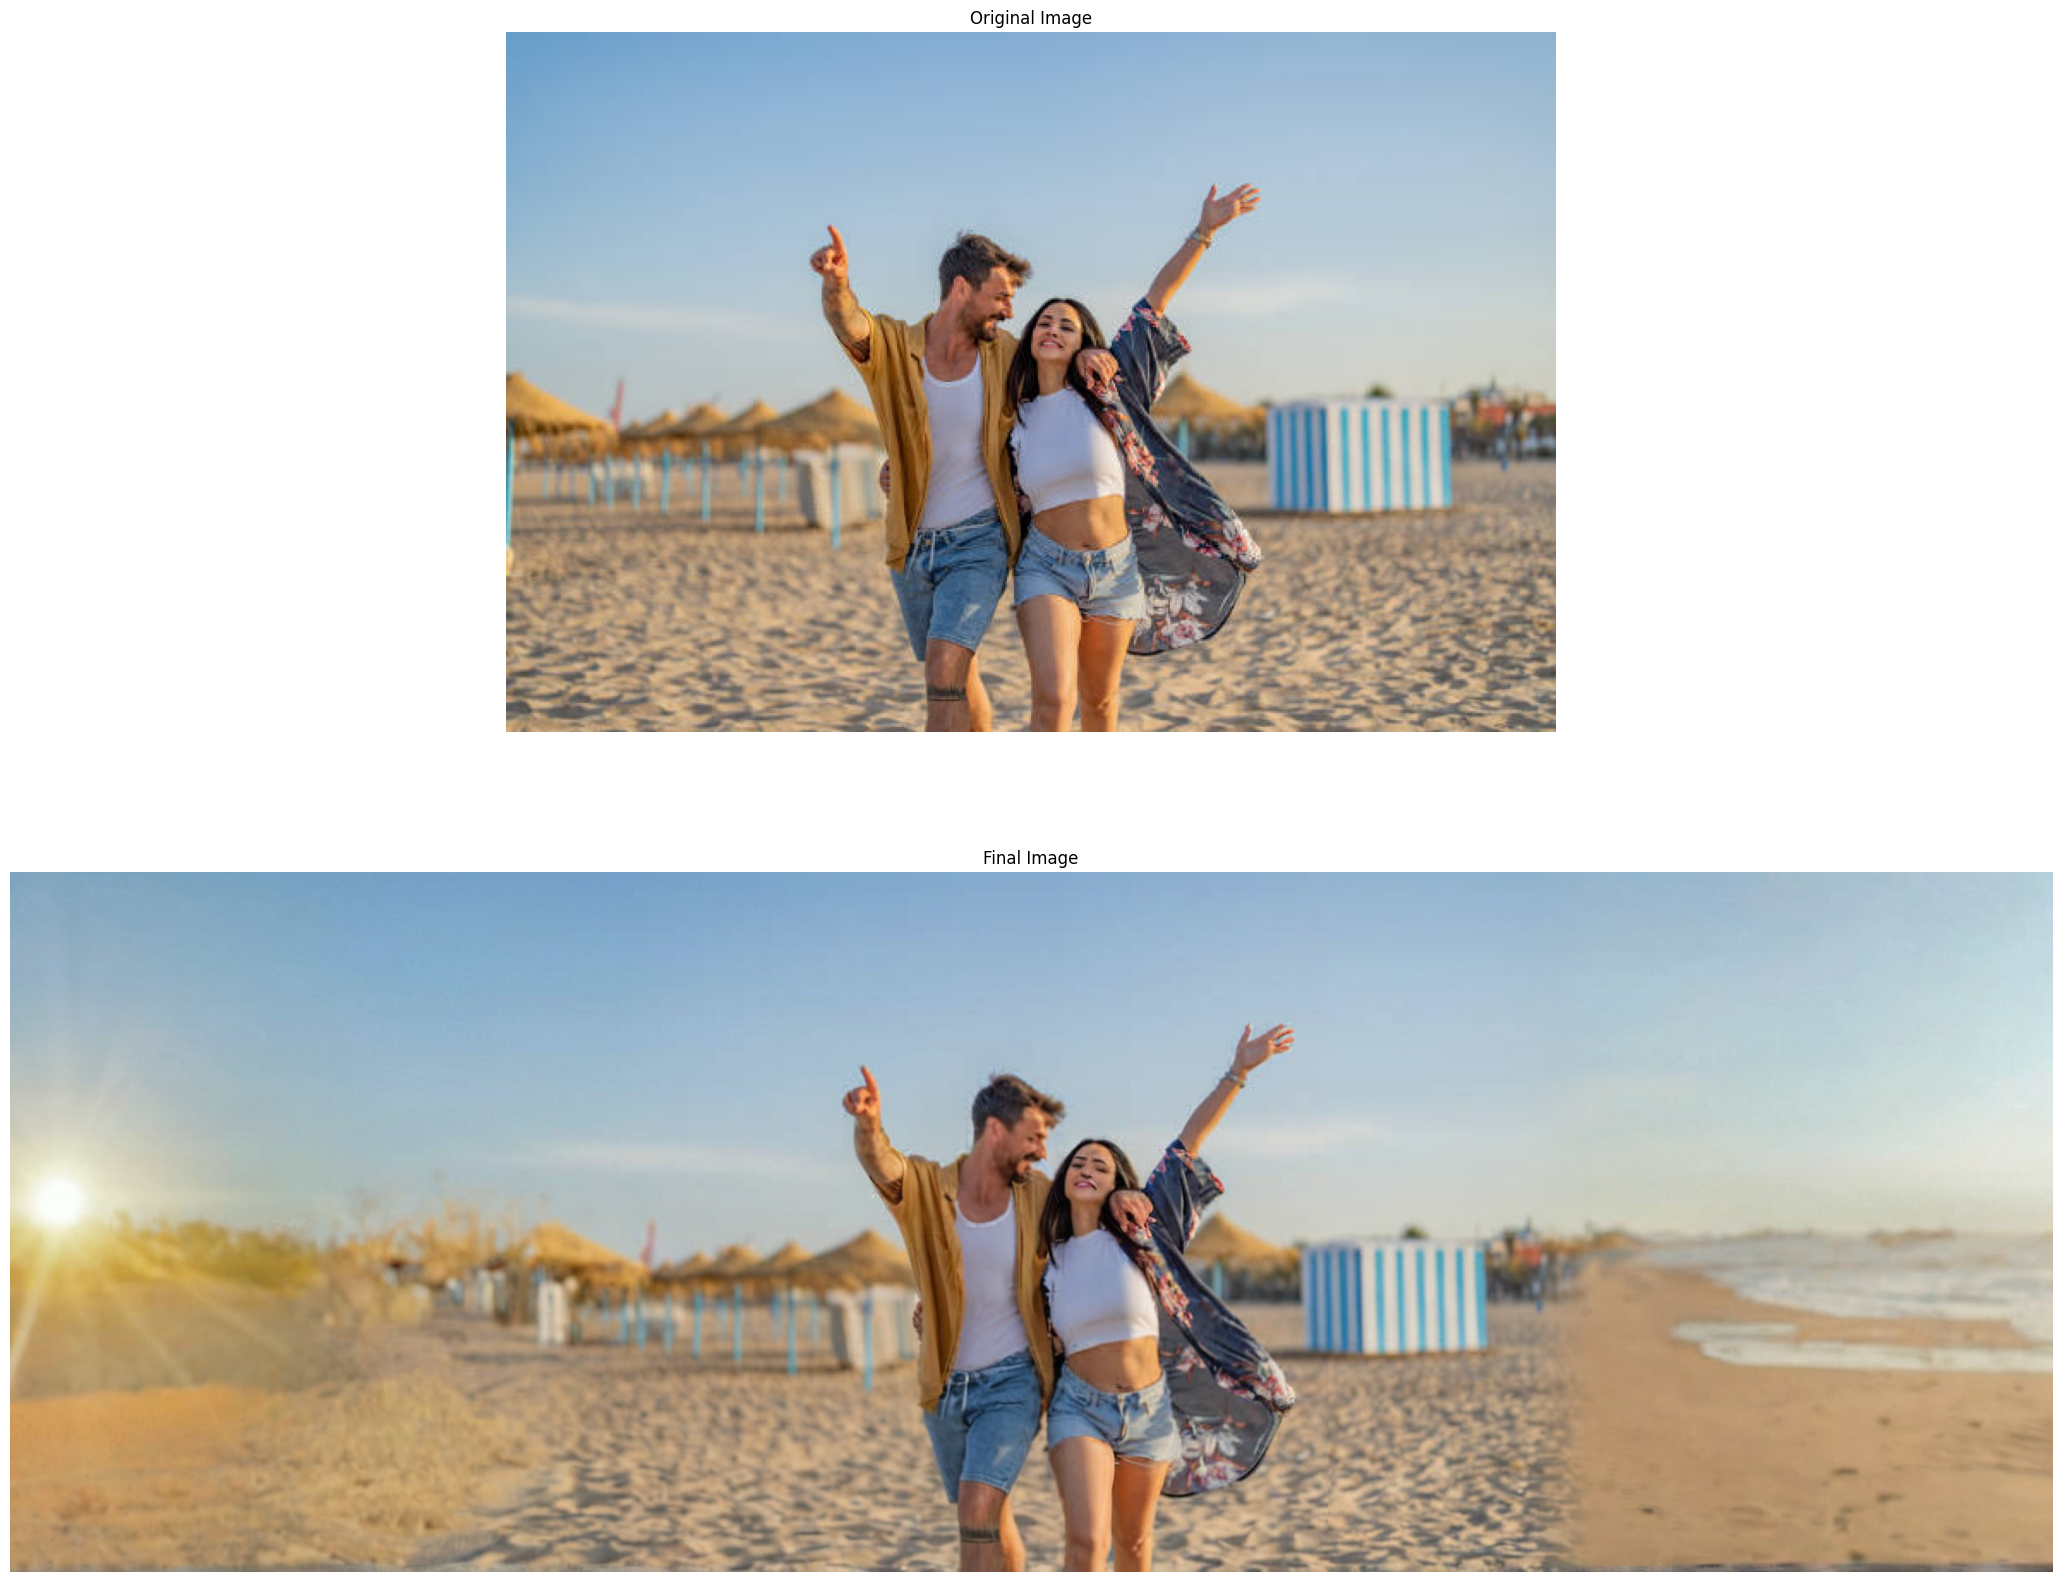

In [17]:
display(final_image)

In [19]:
final_image , generated_images = generate_final_image(vertical, image_np)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

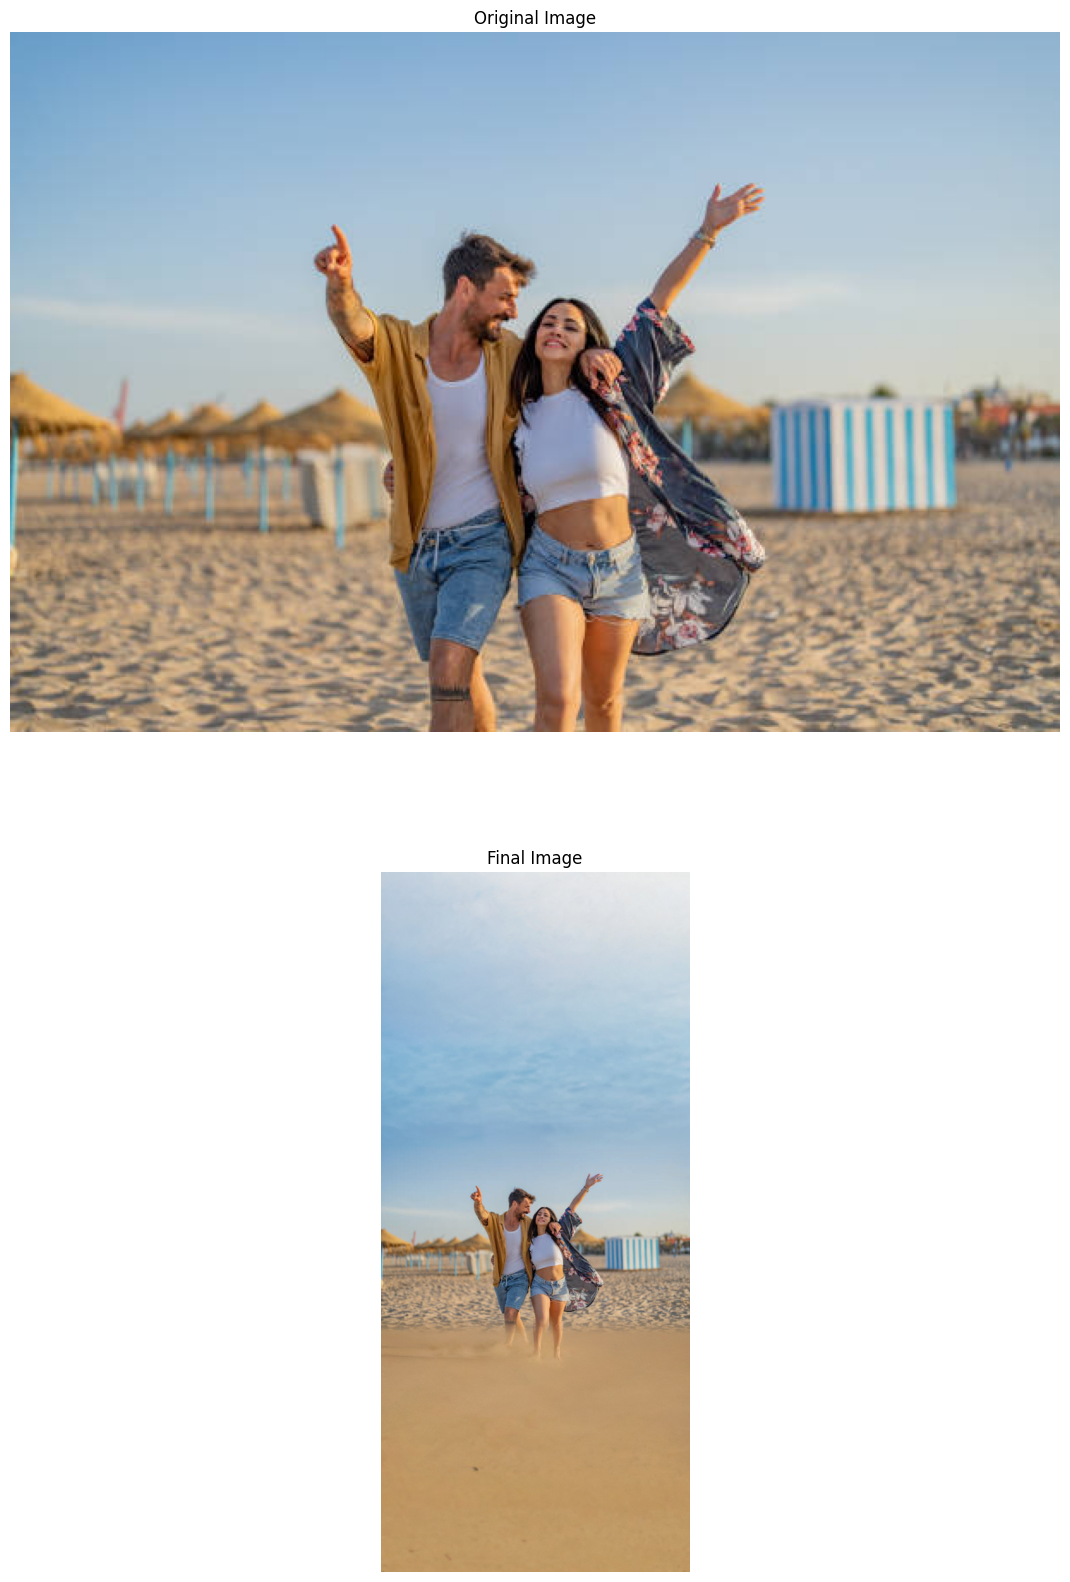

In [20]:
display(final_image)